# WISE BPIC 2019 – Full P2P Analysis Notebook (Business-Facing)

This notebook is meant to be used with your WISE library and the BPIC 2019
Purchase-to-Pay (P2P) log. It supports:

- Selecting **which part of the P2P process** to analyse (e.g. only Standard POs),
- Visualising main process flows per document type with **pm4py**,
- Scoring each PO line with **WISE** (norm-based scoring),
- Ranking slices by **Priority Index (PI)**,
- Ranking **layer × slice anomalies** (severity × volume),
- Explaining anomalies with **SHAP**,
- Spotting unusual cases with **outlier detection**,
- Translating findings into **concrete actions** for P2P stakeholders.

All code is organised into cells and math is formatted for Jupyter Markdown.

---

## 0. Setup and configuration

In [36]:
# If needed, install extra packages once in your environment, e.g.:
#
#   pip install jupyter pm4py plotly ipywidgets seaborn shap scikit-learn
#
# (WISE itself should already be installed in your environment.)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path


import pm4py

from wise.io.log_loader import load_event_log
from wise.io.norm_loader import load_norm_from_json
from wise.scoring.scoring import compute_case_scores
from wise.scoring.slices import aggregate_slices
from wise.norm import compute_view_weights

# Paths to data and norm (adapt to your repo layout)
LOG_PATH = "../../../data/BPI_Challenge_2019.csv"
NORM_PATH = "../../../data/WISE_BPIC_Norm.json"

# Column names in the BPIC 2019 log (as produced by your pipeline)
CASE_ID_COL = "case concept:name"
ACTIVITY_COL = "event concept:name"
TIMESTAMP_COL = "event time:timestamp"

# Candidate slice dimensions (adjust to your own file)
SLICE_COLS = [
    "case Spend area text",
    "case Company",
    "case Document Type",
    "case Purch. Doc. Category",
    "case Item Type",
    "case Item Category",
    "case Spend classification text",
    "case Source",
    "case GR-Based Inv. Verif.",
    "case Goods Receipt",
]

# Default view to analyse (Finance / Logistics / Automation / ...)
VIEW_NAME = "Finance"

---

## 1. Load and inspect the event log

In [37]:
# Load raw CSV (using latin1 to avoid UnicodeDecodeError in this dataset)
df_raw = pd.read_csv(LOG_PATH, encoding="latin1", low_memory=False)
print(f"Raw log: {df_raw.shape[0]} rows, {df_raw[CASE_ID_COL].nunique()} cases")

# Normalise using WISE's loader (parses timestamps etc.)
df_log = load_event_log(
    df_raw,
    case_id_col=CASE_ID_COL,
    activity_col=ACTIVITY_COL,
    timestamp_col=TIMESTAMP_COL,
)

print(f"Normalised log: {df_log.shape[0]} events, {df_log[CASE_ID_COL].nunique()} cases")
df_log.head()

Raw log: 1595923 rows, 251734 cases
Normalised log: 1595923 events, 251734 cases


/Users/ula/code/PhD/WISE/WISE/Untitled/src/wise/io/log_loader.py:46: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S.%f format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce")


,eventID,case Spend area text,case Company,case Document Type,case Sub spend area text,case Purchasing Document,case Purch. Doc. Category name,case Vendor,case Item Type,case Item Category,...,case Name,case GR-Based Inv. Verif.,case Item,case concept:name,case Goods Receipt,event User,event org:resource,event concept:name,event Cumulative net worth (EUR),event time:timestamp
0,65781719105536,Sales,companyID_0000,Standard PO,Products for Resale,4507004931,Purchase order,vendorID_0670,Standard,"3-way match, invoice before GR",...,vendor_0645,False,20,4507004931_00020,True,NONE,NONE,Vendor creates invoice,68.0,1948-01-26 23:59:00
1,65777424138241,Sales,companyID_0000,Standard PO,Products for Resale,4507004931,Purchase order,vendorID_0670,Standard,"3-way match, invoice before GR",...,vendor_0645,False,10,4507004931_00010,True,NONE,NONE,Vendor creates debit memo,325.0,1948-01-26 23:59:00
2,65777424138240,Sales,companyID_0000,Standard PO,Products for Resale,4507004931,Purchase order,vendorID_0670,Standard,"3-way match, invoice before GR",...,vendor_0645,False,10,4507004931_00010,True,NONE,NONE,Vendor creates invoice,325.0,1948-01-26 23:59:00
3,65794604007424,Sales,companyID_0000,Standard PO,Products for Resale,4507004931,Purchase order,vendorID_0670,Standard,"3-way match, invoice before GR",...,vendor_0645,False,50,4507004931_00050,True,NONE,NONE,Vendor creates invoice,102.0,1948-01-26 23:59:00
4,65794604007425,Sales,companyID_0000,Standard PO,Products for Resale,4507004931,Purchase order,vendorID_0670,Standard,"3-way match, invoice before GR",...,vendor_0645,False,50,4507004931_00050,True,NONE,NONE,Vendor creates debit memo,102.0,1948-01-26 23:59:00


Optional: explore columns and candidate filters.

In [38]:
df_log.columns

Index(['eventID ', 'case Spend area text', 'case Company',
       'case Document Type', 'case Sub spend area text',
       'case Purchasing Document', 'case Purch. Doc. Category name',
       'case Vendor', 'case Item Type', 'case Item Category',
       'case Spend classification text', 'case Source', 'case Name',
       'case GR-Based Inv. Verif.', 'case Item', 'case concept:name',
       'case Goods Receipt', 'event User', 'event org:resource',
       'event concept:name', 'event Cumulative net worth (EUR)',
       'event time:timestamp'],
      dtype='object')

In [39]:
df_log["case Document Type"].value_counts().head(10)

case Document Type
Standard PO          1539913
Framework order        33649
EC Purchase order      22361
Name: count, dtype: int64

---

## 2. Choose which part of the P2P process to analyse

The data provider mentioned three main types of P2P processes, often encoded
in attributes such as:

- `case Document Type` (Standard PO, Framework order, EC Purchase order, …),
- `case Item Category` (3-way, 2-way, consignment, …),
- `case Source` (e.g. Purchase order vs Free text).

It is usually more informative to analyse **one process type at a time** and
compare their flows, instead of mixing them into a single “spaghetti” model.

We define a generic filter applied at case level:

$$
L' = \{\, e \in L \mid f(\text{case}(e)) \,\},
$$

where $f$ is a Boolean predicate over case attributes.

Below, we define a dictionary of filters that can include multiple conditions
(e.g. Standard POs in a given company).

In [40]:
import numpy as np

# -------------------------------------------------------------
# Generic filters: set USE_FILTERS=False to analyse full log
# -------------------------------------------------------------
USE_FILTERS = True

# FILTERS maps: column_name -> list of acceptable values.
# Edit this dictionary to focus on one process type or scenario.
FILTERS = {
    "case Document Type": ["Standard PO"],  # e.g. only Standard POs
    # "case Source": ["Purchase order"],    # uncomment/add to refine
    # "case Company": ["companyID_0000"],   # example: restrict to one company
}

def apply_case_filters(df, case_id_col, filters):
    # Restrict a log DataFrame to cases satisfying all column filters.
    #
    # filters: dict[col -> list of values]
    if not filters:
        return df.copy()

    mask = np.ones(len(df), dtype=bool)
    for col, values in filters.items():
        if col not in df.columns:
            print(f"Warning: column {col!r} not in log; skipping this filter.")
            continue
        mask &= df[col].isin(values)

    valid_cases = df.loc[mask, case_id_col].unique()
    return df[df[case_id_col].isin(valid_cases)].copy()

if USE_FILTERS:
    df_sub = apply_case_filters(df_log, CASE_ID_COL, FILTERS)
    print(
        f"Filtered log: {df_sub.shape[0]} events, "
        f"{df_sub[CASE_ID_COL].nunique()} cases, "
        f"filters={FILTERS}"
    )
else:
    df_sub = df_log.copy()
    print(f"Using full log: {df_sub.shape[0]} events, {df_sub[CASE_ID_COL].nunique()} cases")

Filtered log: 1539913 events, 248755 cases, filters={'case Document Type': ['Standard PO']}


Now the **entire notebook** runs on this subset (e.g. only Standard POs).

---

## 3. Visualise the main process flow (pm4py)

To give stakeholders a structural picture, we visualise the main process flow
for the selected subset using pm4py. We show one simplified DFG per document
type inside the currently selected subset.

Document types present in subset: ['Standard PO']

Document type: Standard PO
  Events: 1539913, Cases: 248755
  Showing main DFG (≈80% of edge frequency)...


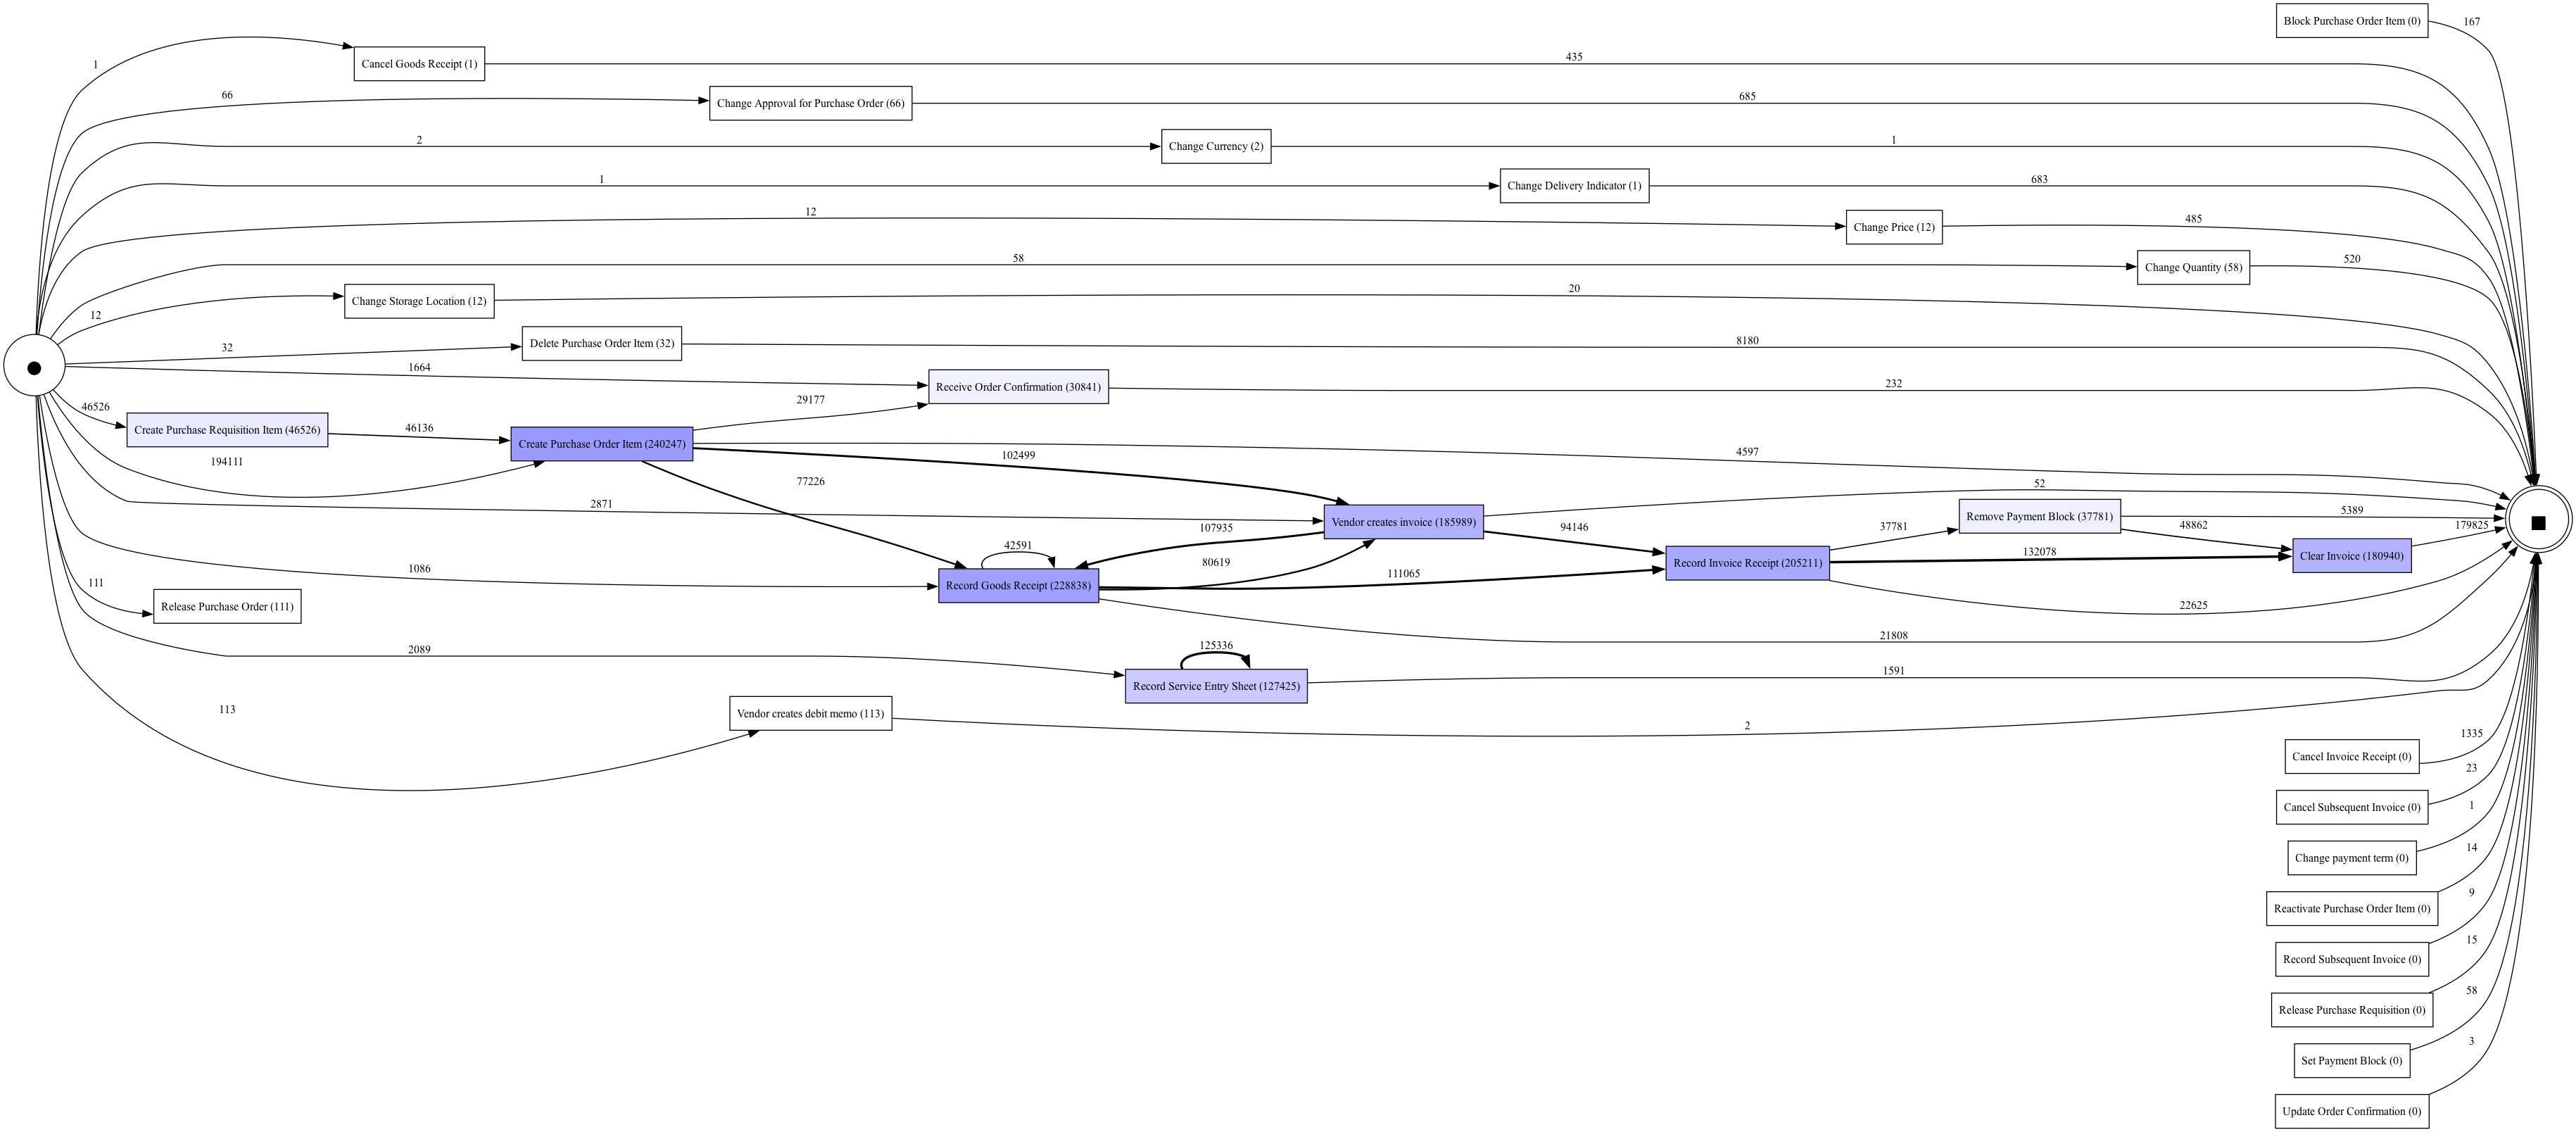

In [41]:
def filter_dfg_by_edge_coverage(dfg, coverage: float = 0.8):
    # Keep the most frequent edges in a DFG until the given coverage threshold
    # of total frequency is reached.
    #
    # dfg: dict[(act_from, act_to) -> frequency]
    # coverage: fraction of total edge frequency to keep (e.g. 0.8 = 80%).
    if not dfg:
        return dfg

    items = sorted(dfg.items(), key=lambda x: x[1], reverse=True)
    total = sum(freq for _, freq in items)
    if total <= 0:
        return dfg

    kept = {}
    cum = 0.0
    for (edge, freq) in items:
        kept[edge] = freq
        cum += freq
        if cum / total >= coverage:
            break
    return kept

doc_types = df_sub["case Document Type"].dropna().unique().tolist()
print("Document types present in subset:", doc_types)

for doc_type in doc_types:
    print("\n============================")
    print(f"Document type: {doc_type}")

    df_dt = df_sub[df_sub["case Document Type"] == doc_type].copy()
    n_events = len(df_dt)
    n_cases = df_dt[CASE_ID_COL].nunique()
    print(f"  Events: {n_events}, Cases: {n_cases}")

    df_pm_dt = df_dt[[CASE_ID_COL, ACTIVITY_COL, TIMESTAMP_COL]].rename(
        columns={CASE_ID_COL: "case_id", ACTIVITY_COL: "activity", TIMESTAMP_COL: "timestamp"}
    )

    df_pm_dt = pm4py.format_dataframe(
        df_pm_dt,
        case_id="case_id",
        activity_key="activity",
        timestamp_key="timestamp",
    )

    dfg, start_activities, end_activities = pm4py.discover_dfg(df_pm_dt)

    dfg_main = filter_dfg_by_edge_coverage(dfg, coverage=0.8)

    print("  Showing main DFG (≈80% of edge frequency)...")
    pm4py.view_dfg(dfg_main, start_activities, end_activities)

Stakeholders can now compare **per-doc-type** flows instead of a single
spaghetti model.

---

## 4. Load the WISE norm and select a view

In [42]:
with open(NORM_PATH, "r", encoding="utf-8") as f:
    norm = load_norm_from_json(f)

print("Norm views:", norm.get_view_names())
print("Number of constraints:", len(norm.constraints))

VIEW_NAME = VIEW_NAME if VIEW_NAME in norm.get_view_names() else norm.get_view_names()[0]
print("Using view:", VIEW_NAME)

Norm views: ['Finance', 'Logistics', 'Automation']
Number of constraints: 16
Using view: Finance


Mathematically, the norm is a set of constraints $C$ over cases, grouped
into layers (presence, order/lag, balance, singularity, exclusion). For each
view $v$ we have weights $w_c^{(v)}$ per constraint, and the WISE
score for a case $\sigma$ is:

$$
S^{(v)}(\sigma) = 1 - \sum_{c \in C} w_c^{(v)}\, v_c(\sigma),
\quad S^{(v)} \in [0,1],
$$

where $v_c(\sigma)$ is a bounded violation measure for constraint $c$.

---

## 5. Compute case-level WISE scores

### How to read the WISE scores

All WISE scores in this notebook follow the same convention:

- **Case score** `score` is in `[0, 1]`  
  - `1.0`  → the case perfectly satisfies all constraints in the norm for the selected view (does not violate anything). 
  - `0.0`  → maximum possible violation of the norm (every constraint fully violated).  
  - `0.93` vs `0.80` → the latter is clearly worse: more weighted violations.

Let:

- $ C $ be the set of constraints in the norm.
- $ w_c^{(v)} $ be the weight of constraint $c$ in view $v$.
- $ v_c(\sigma) \in [0,1] $ be the violation of constraint $c$ for case $\sigma$.

Then the WISE score of a case is

$$
S^{(v)}(\sigma)
= 1 - \sum_{c \in C} w_c^{(v)}\, v_c(\sigma), \qquad S^{(v)}(\sigma) \in [0,1].
$$

Higher is **better** (closer to the norm). A difference of `0.05` in score can be
interpreted as “about 5 percentage‑points more weighted violation”.

For slices (groups of cases) we use:

- `mean_score` = average case score in the slice (again, higher = better).
- `gap` = `global_mean_score - mean_score`  
  - `gap > 0` → slice is **worse than average** (lower scores).  
  - `gap < 0` → slice is **better than average** (higher scores).
- `PI` (Priority Index) = `n_cases * gap`  
  - combines **severity** (`gap`) and **volume** (`n_cases`); larger PI ⇒ more important.

For layers we use **mean violation** (not scores):

- `layer_violation` is in `[0,1]` (0 = no violation, 1 = systematic violation).
- `layer_gap = mean_violation_slice - mean_violation_global`  
  - `layer_gap > 0` ⇒ that layer is more problematic in the slice.
- All layer heatmaps in this notebook show “**worse than global**” in warm colours (yellow–red) and “better than global” in green.


In [43]:
from pathlib import Path

# ------------------------------------------------------------------
# save or load case_scores to disk for reuse / download
# ------------------------------------------------------------------
LOAD_SCORES = True   # set True if you want to load previously saved scores
SAVE_SCORES = False  # set True if you want to save scores after computing

SCORES_BASE_NAME = f"case_scores_{VIEW_NAME.replace(' ', '_')}"
PATH_SCORES_CSV = Path("../../../data/results") / f"{SCORES_BASE_NAME}.csv"

case_scores = None

if LOAD_SCORES and PATH_SCORES_CSV.exists():
    print(f"Loading previously saved case scores from {PATH_SCORES_CSV}...")
    case_scores = pd.read_csv(PATH_SCORES_CSV)
else:
    print("Computing case scores from df_sub...")
    case_scores = compute_case_scores(
        df=df_sub,
        norm=norm,
        view_name=VIEW_NAME,
        case_id_col=CASE_ID_COL,
        activity_col=ACTIVITY_COL,
        timestamp_col=TIMESTAMP_COL,
    )

print("Case scores shape:", case_scores.shape)
display(case_scores.head(30))

if SAVE_SCORES:
    out_dir = PATH_SCORES_CSV.parent
    out_dir.mkdir(parents=True, exist_ok=True)

    csv_path = PATH_SCORES_CSV
    parquet_path = out_dir / f"{SCORES_BASE_NAME}.parquet"

    case_scores.to_csv(csv_path, index=False)
    case_scores.to_parquet(parquet_path, index=False)

    print("Saved case scores to:")
    print("  CSV    :", csv_path)
    print("  Parquet:", parquet_path)
else:
    print("Not saving case scores (SAVE_SCORES = False).")


Loading previously saved case scores from ../../../data/results/case_scores_Finance.csv...
Case scores shape: (248755, 22)


,case concept:name,score,violation_exclusion,violation_order_lag,violation_presence,violation_singularity,viol_c_l1_create_po,viol_c_l1_gr,viol_c_l1_inv,viol_c_l1_clear,...,viol_c_l2_inv_to_clear_30d,viol_c_l4_sing_gr,viol_c_l4_sing_inv,viol_c_l4_sing_ses,viol_c_l4_sing_change_price,viol_c_l4_sing_change_quantity,viol_c_l5_excl_cancel_invoice,viol_c_l5_excl_cancel_gr,viol_c_l5_excl_subseq_invoice,viol_c_l5_excl_subseq_credit
0,4507000221_00010,0.891304,0.00,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4507000222_00010,0.891304,0.00,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4507000222_00020,0.891304,0.00,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4507000223_00010,0.891304,0.00,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4507000224_00010,0.949275,0.00,0.155556,0.0,0.0,0.0,0.0,0.0,0.0,...,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4507000225_00010,1.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4507000225_00020,1.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4507000225_00030,1.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4507000225_00040,1.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4507000226_00010,0.891304,0.00,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Not saving case scores (SAVE_SCORES = False).


---

## 6. Attach slice attributes and compute slice-level PI

Let $s$ be a slice (e.g., `Company × Spend area × Item Category`), and let
$S(\sigma)$ be scores for cases in that slice. We define:

- `mean_score` $\mu_s = \mathbb{E}[S(\sigma) \mid \sigma \in s]$,
- `global_mean` $\bar{\mu} = \mathbb{E}[S(\sigma)]$,
- `gap` $= \bar{\mu} - \mu_s$ (positive when the slice is worse than global),
- $\mathrm{PI}_s = |s| \cdot \text{gap}$ (volume-weighted gap).

In [44]:
available_slice_cols = [c for c in SLICE_COLS if c in df_sub.columns]
print("Available slice columns:", available_slice_cols)

if available_slice_cols:
    slice_summary = aggregate_slices(
        df_scores=case_scores,
        df_log=df_sub,
        case_id_col=CASE_ID_COL,
        slice_cols=available_slice_cols,
        shrink_k=50.0,
    )
    print("Slice summary shape:", slice_summary.shape)
    slice_summary.head(20)
else:
    slice_summary = None
    print("No slice columns available; skipping slice-level aggregation.")


Available slice columns: ['case Spend area text', 'case Company', 'case Document Type', 'case Item Type', 'case Item Category', 'case Spend classification text', 'case Source', 'case GR-Based Inv. Verif.', 'case Goods Receipt']
Slice summary shape: (75, 14)


In [45]:
if slice_summary is not None:
    top_slices = slice_summary.sort_values("PI", ascending=False).head(20)
    top_slices

---

## 7. Layer × slice anomaly ranking

For each layer $\ell$ and slice $s$:

- $n_s$: number of cases in slice $s$,
- $\bar{v}_{\ell,s}$: mean violation for layer $\ell$ in slice $s$,
- $\bar{v}_{\ell,\mathrm{global}}$: global mean violation for layer $\ell$,
- gap: $g_{\ell,s} = \bar{v}_{\ell,s} - \bar{v}_{\ell,\mathrm{global}}$,
- std: $\sigma_\ell$: global std of violation for layer $\ell$,
- severity (z-score): $z_{\ell,s} = g_{\ell,s} / \sigma_\ell$ (if $\sigma_\ell>0$),
- positive part: $z^+_{\ell,s} = \max(z_{\ell,s},0)$.

Volume weight:

$$
w_{\text{vol}}(n_s; k) = \frac{n_s}{n_s + k},
$$

priority score:

$$
P_{\ell,s} = z^+_{\ell,s} \cdot w_{\text{vol}}(n_s; k),
$$

classic slice-layer PI:

$$
\mathrm{PI}_{\ell,s} = n_s \cdot \max(g_{\ell,s}, 0).
$$

### 7.1 Implementation

In [46]:
from typing import List

def compute_layer_slice_anomalies(
    case_scores: pd.DataFrame,
    df_log: pd.DataFrame,
    case_id_col: str,
    slice_cols: List[str],
    k_volume: float = 50.0,
) -> pd.DataFrame:
    # Compute anomaly scores for each (layer, slice) pair.

    layer_cols_map = {
        col[len("violation_"):]: col
        for col in case_scores.columns
        if col.startswith("violation_")
    }
    if not layer_cols_map:
        raise ValueError("No layer violation columns found (violation_*).")

    key_df = df_log[[case_id_col] + slice_cols].drop_duplicates()
    merged = case_scores.merge(key_df, on=case_id_col, how="left")

    global_means = {}
    global_stds = {}
    for lid, col in layer_cols_map.items():
        vals = merged[col].to_numpy()
        global_means[lid] = float(np.nanmean(vals))
        std = float(np.nanstd(vals))
        if not np.isfinite(std) or std <= 0:
            std = 0.0
        global_stds[lid] = std

    grouped = merged.groupby(slice_cols, dropna=False)
    means = grouped[list(layer_cols_map.values())].mean()
    counts = grouped[case_id_col].size()

    records = []
    for idx, idx_label in enumerate(means.index):
        if isinstance(idx_label, tuple):
            slice_values = list(idx_label)
        else:
            slice_values = [idx_label]
        slice_dict = {col_name: val for col_name, val in zip(slice_cols, slice_values)}
        n_cases = int(counts.to_numpy()[idx])

        for lid, col in layer_cols_map.items():
            mean_v = float(means[col].to_numpy()[idx])
            global_mean = global_means[lid]
            std = global_stds[lid]
            gap = mean_v - global_mean
            if std > 0:
                z = gap / std
            else:
                z = 0.0
            z_plus = max(z, 0.0)

            if k_volume > 0:
                vol_weight = n_cases / (n_cases + k_volume)
            else:
                vol_weight = 1.0

            priority = z_plus * vol_weight
            pi = max(gap, 0.0) * n_cases

            rec = dict(slice_dict)
            rec.update(
                {
                    "slice_label": " | ".join(str(v) for v in slice_values),
                    "layer_id": lid,
                    "n_cases": n_cases,
                    "mean_violation": mean_v,
                    "global_mean": global_mean,
                    "gap": gap,
                    "z": z,
                    "z_plus": z_plus,
                    "vol_weight": vol_weight,
                    "priority": priority,
                    "PI": pi,
                }
            )
            records.append(rec)

    return pd.DataFrame.from_records(records)

### 7.2 Use it and rank anomalies

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_layer_slice_heatmap(
    df_heat: pd.DataFrame,
    value_col: str,
    title: str,
    vcenter: float | None = 0.0,
    fmt: str = ".3f",
    cmap: str = "RdYlGn_r",
    figsize_scale: float = 0.5,
):
    """
    Generic, high-res heatmap for layer × slice matrices.

    df_heat must have columns: ['layer_id', 'slice_label', value_col]
    value_col is typically 'gap', 'z_plus', or 'priority'.
    """
    if df_heat.empty:
        print("No data to plot.")
        return

    # Pivot to layer × slice matrix
    mat = df_heat.pivot(index="layer_id", columns="slice_label", values=value_col)

    # Sort layers in a logical order
    desired_order = ["presence", "order_lag", "balance", "singularity", "exclusion"]
    order = [l for l in desired_order if l in mat.index] + [
        l for l in mat.index if l not in desired_order
    ]
    mat = mat.loc[order]

    # Sanitize labels for long slice names
    mat.columns = [str(c) for c in mat.columns]
    mat.index = [str(i) for i in mat.index]

    # Figure size scales with number of slices
    fig_w = max(8, figsize_scale * mat.shape[1])
    fig_h = 5
    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=160)

    # Define centre of colour scale if needed (e.g. 0 for "no deviation")
    if vcenter is not None:
        vmin = np.nanmin(mat.values)
        vmax = np.nanmax(mat.values)
        vmax_abs = max(abs(vmin), abs(vmax))
        vmin, vmax = -vmax_abs, vmax_abs
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
    else:
        norm = None

    sns.heatmap(
        mat,
        ax=ax,
        cmap=cmap,
        annot=True,
        fmt=fmt,
        linewidths=0.5,
        linecolor="white",
        square=True,
        cbar_kws={"label": f"{value_col} (layer deviation)"},
        norm=norm,
    )

    ax.set_xlabel("Slice", fontsize=11)
    ax.set_ylabel("Layer", fontsize=11)
    ax.set_title(title, fontsize=14, pad=12)

    # Rotate x labels for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()


In [48]:
from dataclasses import dataclass

@dataclass
class Hotspot:
    dim: str
    category: str
    n_cases: int
    total_priority: float
    top_layer: str
    top_layer_priority: float
    mean_score: float
    global_mean_score: float

def build_hotspot_ranking(
    case_scores: pd.DataFrame,
    df_log: pd.DataFrame,
    case_id_col: str,
    slice_cols: list[str],
    shrink_k: float = 50.0,
    min_cases: int = 30,
) -> pd.DataFrame:
    """
    Aggregate all layer × slice priorities into one 'hotspot' table.

    - For each dimension and category, compute:
        * n_cases, mean_score, gap
        * layer-wise gap and priority (z-score × volume weight)
    - Return a flat ranking of (dimension, category) with an overall score.
    """
    # 1) Attach slice attributes to case_scores
    slice_df = df_log[[case_id_col] + slice_cols].drop_duplicates()
    joined = case_scores.merge(slice_df, on=case_id_col, how="left")

    # 2) Identify layer violation columns
    layer_cols = [c for c in joined.columns if c.startswith("violation_")]
    if not layer_cols:
        raise ValueError("No layer violation columns found (expected columns starting with 'violation_').")

    # 3) Precompute global layer stats
    global_layer_means = joined[layer_cols].mean()
    global_layer_stds = joined[layer_cols].std().replace(0, np.nan)

    global_mean_score = joined["score"].mean()

    hotspots: list[Hotspot] = []

    for dim in slice_cols:
        for cat, sub in joined.groupby(dim, dropna=False):
            cat_label = str(cat)
            n_s = sub[case_id_col].nunique()
            if n_s < min_cases:
                continue

            mean_score = sub["score"].mean()
            gap = global_mean_score - mean_score  # >0 => worse than global

            # Volume weight (Empirical-Bayes-like)
            vol_weight = n_s / (n_s + shrink_k)

            # Layer-level contributions
            layer_priorities = {}
            for col in layer_cols:
                layer_id = col.replace("violation_", "")
                mean_violation_slice = sub[col].mean()
                mean_violation_global = global_layer_means[col]
                g = mean_violation_slice - mean_violation_global
                z = g / global_layer_stds[col] if pd.notna(global_layer_stds[col]) else 0.0
                z_plus = max(z, 0.0)
                layer_priorities[layer_id] = z_plus * vol_weight

            if not layer_priorities:
                continue

            top_layer = max(layer_priorities, key=layer_priorities.get)
            top_layer_priority = layer_priorities[top_layer]
            total_priority = sum(layer_priorities.values()) * gap  # emphasise slices that are both structurally bad and have volume

            hotspots.append(
                Hotspot(
                    dim=dim,
                    category=cat_label,
                    n_cases=n_s,
                    total_priority=total_priority,
                    top_layer=top_layer,
                    top_layer_priority=top_layer_priority,
                    mean_score=mean_score,
                    global_mean_score=global_mean_score,
                )
            )

    hot_df = pd.DataFrame([h.__dict__ for h in hotspots])
    hot_df = hot_df.sort_values("total_priority", ascending=False).reset_index(drop=True)
    return hot_df

hotspots = build_hotspot_ranking(
    case_scores=case_scores,
    df_log=df_sub,
    case_id_col=CASE_ID_COL,
    slice_cols=available_slice_cols,
    shrink_k=50.0,
    min_cases=30,
)

hotspots.head(20)


,dim,category,n_cases,total_priority,top_layer,top_layer_priority,mean_score,global_mean_score
0,case Spend area text,Logistics,4919,0.769272,singularity,3.309929,0.697024,0.847575
1,case Item Type,Service,4847,0.625382,singularity,3.403806,0.719716,0.847575
2,case Item Type,Consignment,14498,0.580679,presence,1.740080,0.644008,0.847575
3,case Item Category,Consignment,14498,0.580679,presence,1.740080,0.644008,0.847575
4,case Spend area text,Titanium Dioxides,1863,0.292366,order_lag,1.084456,0.712234,0.847575
5,case Item Type,Subcontracting,4678,0.197092,order_lag,0.878846,0.737713,0.847575
6,case Item Category,"3-way match, invoice after GR",14077,0.061293,singularity,1.191748,0.810337,0.847575
7,case GR-Based Inv. Verif.,True,14077,0.061293,singularity,1.191748,0.810337,0.847575
8,case Spend area text,nan,3233,0.054386,presence,0.577244,0.791337,0.847575
9,case Spend classification text,nan,3233,0.054386,presence,0.577244,0.791337,0.847575


### How to use the hotspot ranking

Each row is a **coarse “where to start” suggestion**:

- `dim` / `category` → which slice dimension and value (e.g. Spend area text = Logistics).  
- `n_cases`          → how many cases are affected.  
- `mean_score`       → average WISE score in that slice (1 = perfect).  
- `total_priority`   → combined layer deviation × volume; high values should be inspected first.  
- `top_layer`        → layer that contributes most to the slice’s priority.  

A recommended workflow:

1. Sort by `total_priority` and take the top 10–20 rows.  
2. For each, note the `dim`, `category` and `top_layer`.  
3. Use the interactive drill‑down below to inspect which **constraints** in that layer
   are driving the problems for that slice.


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Output
from IPython.display import display

# --------------------------------------------------
# 1. Constraint metadata from the norm
#    (assumes: `norm` object already loaded)
# --------------------------------------------------

def describe_constraint(c) -> str:
    """Human-readable description based on layer_id and params."""
    p = getattr(c, "params", {})
    lid = getattr(c, "layer_id", "unknown")
    if lid == "presence":
        return f"Presence of '{p.get('activity')}'"
    elif lid == "order_lag":
        return (f"Order/lag: '{p.get('activity_from')}' → '{p.get('activity_to')}' "
                f"≤ {p.get('max_days')} days")
    elif lid == "balance":
        return (f"Balance: {p.get('qty_col_from')} → {p.get('qty_col_to')} "
                f"(tol={p.get('tolerance')})")
    elif lid == "singularity":
        return f"Singularity: at most once '{p.get('activity')}'"
    elif lid == "exclusion":
        return f"Exclusion: forbid '{p.get('activity')}'"
    else:
        return f"{lid}: {p}"

constraint_meta = pd.DataFrame(
    [
        {
            "constraint_id": c.id,
            "layer_id": c.layer_id,
            "description": describe_constraint(c),
        }
        for c in norm.constraints
    ]
)

# Map from constraint id to violation column name in case_scores
viol_cols = [c for c in case_scores.columns if c.startswith("viol_")]
viol_col_map = {c[5:]: c for c in viol_cols}  # id -> column name

# --------------------------------------------------
# 2. Core drill‑down function
#    (assumes: df_sub, case_scores, CASE_ID_COL defined)
# --------------------------------------------------

out = Output()  # single output area we’ll reuse

def drilldown_layer_slice(slice_dim: str,
                          slice_value: str,
                          layer_id: str,
                          top_n: int = 10):
    """Show which constraints in a given layer are worst for the selected slice."""
    with out:
        out.clear_output()

        if slice_dim is None or slice_value is None:
            print("Select a slice dimension and value.")
            return

        # 1) select cases in slice
        mask = df_sub[slice_dim].astype(str) == str(slice_value)
        case_ids = df_sub.loc[mask, CASE_ID_COL].unique()
        if len(case_ids) == 0:
            print(f"No cases in slice {slice_dim} = {slice_value!r}.")
            return

        sub_scores = case_scores[case_scores[CASE_ID_COL].isin(case_ids)]
        print(f"{len(case_ids)} cases in slice '{slice_dim} = {slice_value}'.")

        # 2) gather constraint violations in that layer
        rows = []
        for _, row in constraint_meta[constraint_meta["layer_id"] == layer_id].iterrows():
            cid = row["constraint_id"]
            col = viol_col_map.get(cid)
            if col is None or col not in case_scores.columns:
                continue

            global_mean = case_scores[col].mean()
            slice_mean = sub_scores[col].mean()
            gap = slice_mean - global_mean

            rows.append(
                {
                    "constraint_id": cid,
                    "description": row["description"],
                    "global_mean_violation": global_mean,
                    "slice_mean_violation": slice_mean,
                    "gap": gap,
                }
            )

        if not rows:
            print("No violation columns found for this layer.")
            return

        df_c = pd.DataFrame(rows).sort_values("gap", ascending=False).head(top_n)

        display(
            df_c.style.format(
                {
                    "global_mean_violation": "{:.3f}",
                    "slice_mean_violation": "{:.3f}",
                    "gap": "{:.3f}",
                }
            )
        )

        # 3) barplot of gaps
        plt.figure(figsize=(9, max(4, 0.4 * len(df_c))), dpi=150)
        sns.barplot(
            data=df_c,
            x="gap",
            y="description",
            color="tab:red",
        )
        plt.xlabel("Extra violation vs global (gap)")
        plt.ylabel("Constraint")
        plt.title(
            f"Worst {layer_id} constraints in slice\n"
            f"'{slice_dim} = {slice_value}'"
        )
        plt.tight_layout()
        plt.show()

# --------------------------------------------------
# 3. ipywidgets UI
#    (assumes: available_slice_cols, df_sub defined)
# --------------------------------------------------

dim_dropdown = widgets.Dropdown(
    options=available_slice_cols,
    description="Slice dim:",
    layout=widgets.Layout(width="250px"),
)

layer_dropdown = widgets.Dropdown(
    options=sorted(constraint_meta["layer_id"].unique()),
    description="Layer:",
    layout=widgets.Layout(width="200px"),
)

value_dropdown = widgets.Dropdown(
    options=[],
    description="Slice value:",
    layout=widgets.Layout(width="300px"),
)

def on_dim_change(change):
    """When the slice dimension changes, update the value dropdown."""
    dim = change["new"]
    if dim is None:
        value_dropdown.options = []
        value_dropdown.value = None
        return

    vals = sorted(df_sub[dim].dropna().astype(str).unique())
    value_dropdown.options = vals
    # pick first value so we always have something to show
    if vals:
        value_dropdown.value = vals[0]
    else:
        value_dropdown.value = None

def on_any_change(change):
    """Redraw whenever any of the selectors changes."""
    if not value_dropdown.options:
        return
    drilldown_layer_slice(
        slice_dim=dim_dropdown.value,
        slice_value=value_dropdown.value,
        layer_id=layer_dropdown.value,
        top_n=10,
    )

dim_dropdown.observe(on_dim_change, names="value")
value_dropdown.observe(on_any_change, names="value")
layer_dropdown.observe(on_any_change, names="value")

# Initialise once
on_dim_change({"new": dim_dropdown.value})
on_any_change(None)

ui = VBox(
    [
        HBox([dim_dropdown, value_dropdown, layer_dropdown]),
        out,
    ]
)

display(ui)


In [50]:
if available_slice_cols:
    key_cols = [c for c in available_slice_cols if "Spend area" in c or "Spend classification" in c]
    if not key_cols:
        key_cols = [available_slice_cols[0]]  # fallback

    print("Using slice key columns:", key_cols)

    anomalies = compute_layer_slice_anomalies(
        case_scores=case_scores,
        df_log=df_sub,
        case_id_col=CASE_ID_COL,
        slice_cols=key_cols,
        k_volume=50.0,
    )
    print("Anomalies shape:", anomalies.shape)
    anomalies.head()
else:
    anomalies = None
    print("No slice columns available for anomaly ranking.")

Using slice key columns: ['case Spend area text', 'case Spend classification text']
Anomalies shape: (76, 13)


In [51]:
if anomalies is not None and not anomalies.empty:
    min_cases = 20
    ranked = anomalies[anomalies["n_cases"] >= min_cases].copy()
    ranked["PI_abs"] = ranked["PI"].abs()

    # Choose ranking metric: 'priority' (recommended) or 'z_plus' or 'PI_abs'
    rank_metric = "priority"

    top_cells = (
        ranked.sort_values(rank_metric, ascending=False)
        [["layer_id", "slice_label", "n_cases", "z_plus", "priority", "gap", "PI"]]
        .head(20)
    )
    top_cells

### 7.3 Heatmap of top anomalies

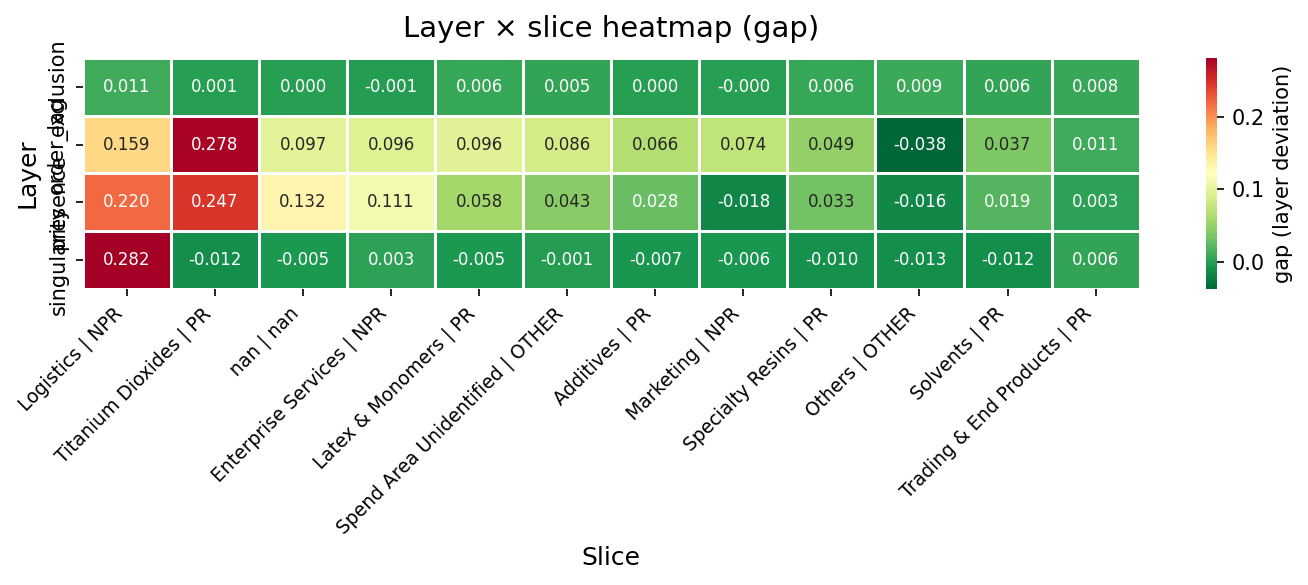

In [52]:

if anomalies is not None and not anomalies.empty:
    top_labels = top_cells["slice_label"].unique().tolist()
    subset = anomalies[anomalies["slice_label"].isin(top_labels)]

    heat_metric = "gap"  # or "z_plus" or "priority"

    heat_data = subset.pivot(
        index="layer_id",
        columns="slice_label",
        values=heat_metric,
    )

    # Sort layers (optional, to get a stable order)
    heat_data = heat_data.sort_index(axis=0)
    # Sort slices by the chosen metric (optional)
    col_order = (
        heat_data.abs().mean(axis=0).sort_values(ascending=False).index
    )
    heat_data = heat_data[col_order]

    # Mask NaNs so they display as blank cells
    mask = heat_data.isna()

    # Make a bigger, higher-DPI figure
    n_cols = heat_data.shape[1]
    fig_width = max(8, 0.8 * n_cols)   # adapt width to number of slices
    fig_height = 4

    fig, ax = plt.subplots(
        figsize=(fig_width, fig_height),
        dpi=150,
    )

    sns.heatmap(
        heat_data,
        mask=mask,
        cmap="RdYlGn_r",
        annot=True,
        fmt=".3f",
        linewidths=0.5,
        linecolor="white",
        cbar_kws={"label": f"{heat_metric} (layer deviation)"},
        ax=ax,
        # If you want to emphasize deviations around 0:
        #center=0.0,
    )

    # Axis titles and tick formatting
    ax.set_xlabel("Slice", fontsize=12)
    ax.set_ylabel("Layer", fontsize=12)
    ax.set_title(f"Layer × slice heatmap ({heat_metric})", fontsize=14, pad=10)

    # Rotate and resize x-tick labels
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        fontsize=9,
    )
    # Slightly larger y-ticks
    ax.set_yticklabels(
        ax.get_yticklabels(),
        fontsize=10,
    )

    # Make annotation text a bit smaller so it fits better
    for text in ax.texts:
        text.set_fontsize(8)

    plt.tight_layout()
    plt.show()
    fig.savefig("layer_slice_heatmap_gap.png", dpi=300, bbox_inches="tight")



---

## 8. SHAP analysis – Why are slices or cases bad?

In [53]:
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

### 8.1 Choose target and features

In [54]:
TARGET_COL = "score"     # or e.g. "violation_singularity"
USE_BADNESS = True       # if True, target = 1 - score

feature_cols = [c for c in SLICE_COLS if c in df_sub.columns]

case_attrs = df_sub[[CASE_ID_COL] + feature_cols].drop_duplicates()
data = case_scores.merge(case_attrs, on=CASE_ID_COL, how="left")

if TARGET_COL == "score" and USE_BADNESS:
    data["target"] = 1.0 - data["score"]
else:
    data["target"] = data[TARGET_COL].astype(float)

data = data.dropna(subset=["target"])
print("Feature columns:", feature_cols)
print("Data shape:", data.shape)
data[feature_cols + ["score", "target"]].head()

Feature columns: ['case Spend area text', 'case Company', 'case Document Type', 'case Item Type', 'case Item Category', 'case Spend classification text', 'case Source', 'case GR-Based Inv. Verif.', 'case Goods Receipt']
Data shape: (248755, 32)


,case Spend area text,case Company,case Document Type,case Item Type,case Item Category,case Spend classification text,case Source,case GR-Based Inv. Verif.,case Goods Receipt,score,target
0,Packaging,companyID_0000,Standard PO,Standard,"3-way match, invoice before GR",PR,sourceSystemID_0000,False,True,0.891304,0.108696
1,Packaging,companyID_0000,Standard PO,Standard,"3-way match, invoice before GR",PR,sourceSystemID_0000,False,True,0.891304,0.108696
2,Packaging,companyID_0000,Standard PO,Standard,"3-way match, invoice before GR",PR,sourceSystemID_0000,False,True,0.891304,0.108696
3,Packaging,companyID_0000,Standard PO,Standard,"3-way match, invoice before GR",PR,sourceSystemID_0000,False,True,0.891304,0.108696
4,Packaging,companyID_0000,Standard PO,Standard,"3-way match, invoice before GR",PR,sourceSystemID_0000,False,True,0.949275,0.050725


### 8.2 Train model and compute SHAP values

In [55]:
X = pd.get_dummies(data[feature_cols], dummy_na=True)
y = data["target"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

print("Train R^2:", rf.score(X_train, y_train))
print("Test R^2:", rf.score(X_test, y_test))

explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test)

Train R^2: 0.2635169266244731
Test R^2: 0.26286767989755533


### 8.3 Global feature importance

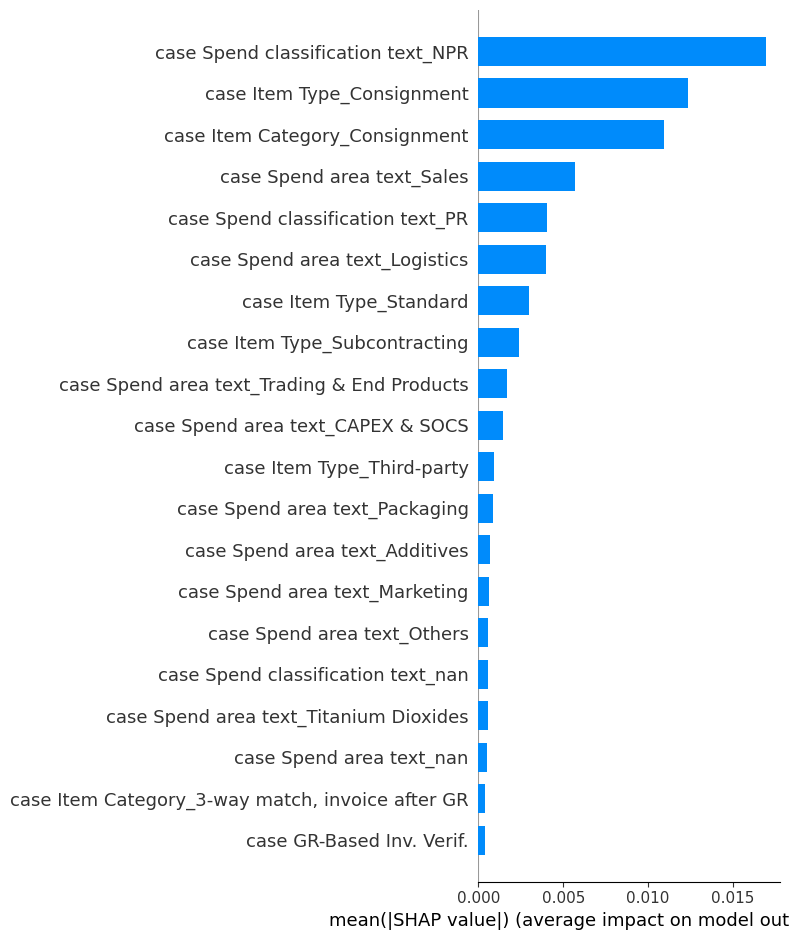

In [56]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### 8.4 Local explanation for a bad case

Worst case target: 0.5652173913043479


,case GR-Based Inv. Verif.,case Goods Receipt,case Spend area text_Additives,case Spend area text_CAPEX & SOCS,case Spend area text_Chemicals & Intermediates,case Spend area text_Commodity Resins,case Spend area text_Enterprise Services,case Spend area text_Latex & Monomers,case Spend area text_Logistics,case Spend area text_Marketing,...,"case Item Category_3-way match, invoice after GR","case Item Category_3-way match, invoice before GR",case Item Category_Consignment,case Item Category_nan,case Spend classification text_NPR,case Spend classification text_OTHER,case Spend classification text_PR,case Spend classification text_nan,case Source_sourceSystemID_0000,case Source_nan
59275,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,True,False,True,False


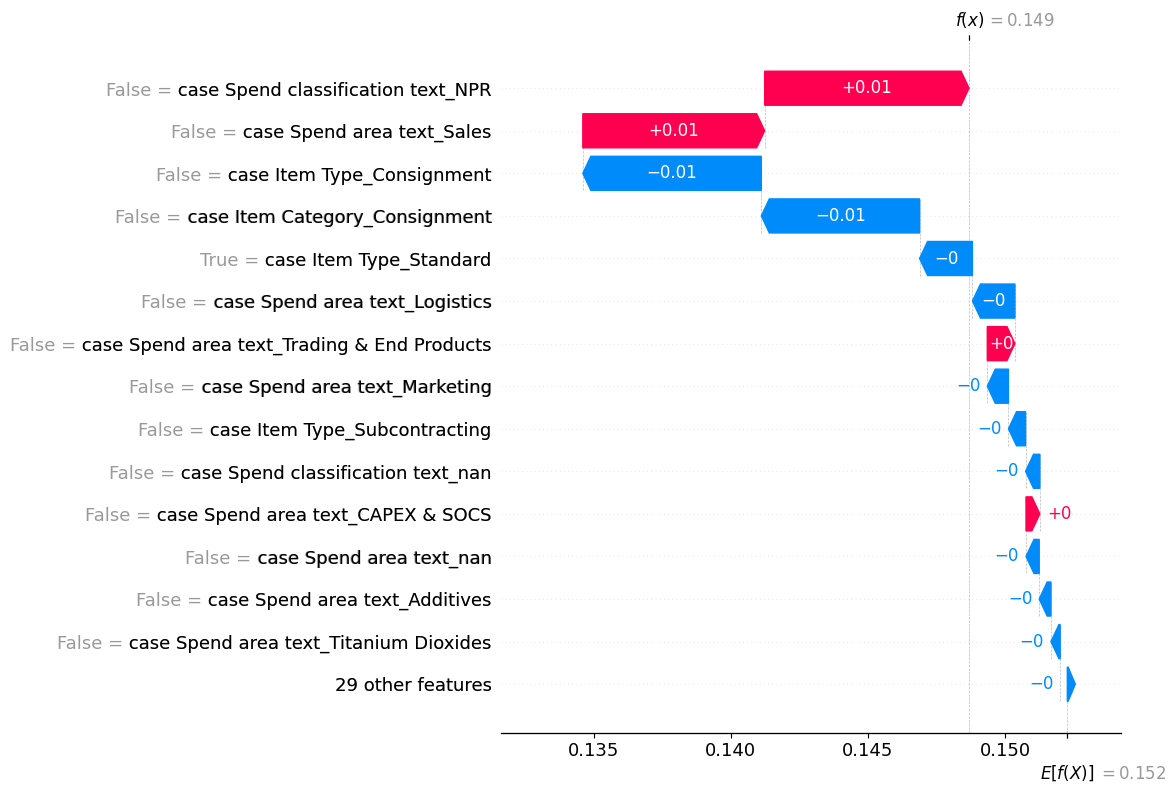

In [57]:
idx_worst = np.argsort(-y_test)[0]
x_worst = X_test.iloc[[idx_worst]]

print("Worst case target:", y_test[idx_worst])
display(x_worst)

shap.plots.waterfall(shap_values[idx_worst], max_display=15)

---

## 9. Outlier analysis – Rare but interesting cases

In [58]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=200,
    contamination="auto",
    random_state=42,
    n_jobs=-1,
)
iso.fit(X)

outlier_score = -iso.score_samples(X)
data["outlier_score"] = outlier_score

if outlier_score.max() > outlier_score.min():
    data["outlier_score_norm"] = (outlier_score - outlier_score.min()) / (outlier_score.max() - outlier_score.min())
else:
    data["outlier_score_norm"] = 0.0

data[["outlier_score_norm", "target"]].describe()

,outlier_score_norm,target
count,248755.000000,248755.000000
mean,0.192798,0.152425
std,0.242565,0.121380
min,0.000000,0.000000
25%,0.024587,0.065217
50%,0.091636,0.108696
75%,0.178115,0.199275
max,1.000000,0.652174


In [59]:
top_outliers = (
    data[[CASE_ID_COL, "outlier_score_norm", "score", "target"] + feature_cols]
    .sort_values("outlier_score_norm", ascending=False)
    .head(20)
)
top_outliers

,case concept:name,outlier_score_norm,score,target,case Spend area text,case Company,case Document Type,case Item Type,case Item Category,case Spend classification text,case Source,case GR-Based Inv. Verif.,case Goods Receipt
87318,4507026074_00010,1.000000,1.000000,0.000000,Others,companyID_0000,Standard PO,Service,"3-way match, invoice after GR",OTHER,sourceSystemID_0000,True,True
218739,4508066833_00010,1.000000,0.586957,0.413043,Others,companyID_0000,Standard PO,Service,"3-way match, invoice after GR",OTHER,sourceSystemID_0000,True,True
26484,4507008414_00010,1.000000,0.956522,0.043478,Others,companyID_0000,Standard PO,Service,"3-way match, invoice after GR",OTHER,sourceSystemID_0000,True,True
240023,4508073378_00010,1.000000,0.586957,0.413043,Others,companyID_0000,Standard PO,Service,"3-way match, invoice after GR",OTHER,sourceSystemID_0000,True,True
172048,4508051844_00010,1.000000,0.891304,0.108696,Others,companyID_0000,Standard PO,Service,"3-way match, invoice after GR",OTHER,sourceSystemID_0000,True,True
16170,4507005429_00010,1.000000,0.978623,0.021377,Others,companyID_0000,Standard PO,Service,"3-way match, invoice after GR",OTHER,sourceSystemID_0000,True,True
41213,4507012954_00010,1.000000,0.990580,0.009420,Others,companyID_0000,Standard PO,Service,"3-way match, invoice after GR",OTHER,sourceSystemID_0000,True,True
212148,4508064768_00010,0.991867,1.000000,0.000000,Others,companyID_0000,Standard PO,Third-party,"3-way match, invoice after GR",OTHER,sourceSystemID_0000,True,True
154768,4508046710_00050,0.991867,0.934783,0.065217,Others,companyID_0000,Standard PO,Third-party,"3-way match, invoice after GR",OTHER,sourceSystemID_0000,True,True
219208,4508067000_00010,0.970137,0.652174,0.347826,Marketing,companyID_0000,Standard PO,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,True,True


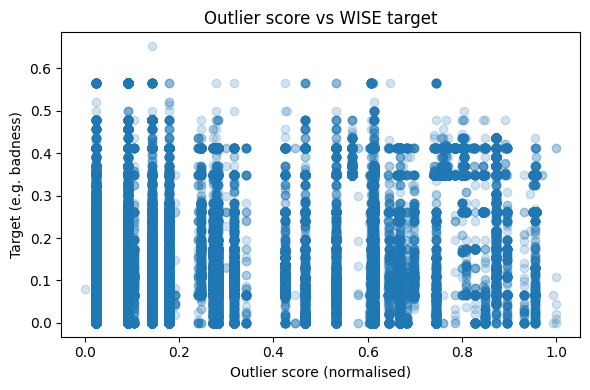

In [60]:
plt.figure(figsize=(6, 4))
plt.scatter(data["outlier_score_norm"], data["target"], alpha=0.2)
plt.xlabel("Outlier score (normalised)")
plt.ylabel("Target (e.g. badness)")
plt.title("Outlier score vs WISE target")
plt.tight_layout()
plt.show()

---

## 10. Requirements additions

Add the following lines to `requirements.txt` if required:

```text
jupyter
notebook
ipykernel
pm4py>=2.7.10
matplotlib
seaborn
scikit-learn
shap
```